## <center>Fama Macbeth Regression</center>

### <center>Get, Format and Check the Data</center>

In [1]:
from helpers import *

returns_portfolio = pd.read_excel('data/NewBloomMonthlyReturns.xlsx', index_col=0, parse_dates=True)
factor_data = pd.read_excel('data_copulas/bloom_Factor_UpsideRatio.xlsx', index_col=0, parse_dates=True)
no_lag_factor_data = factor_data.loc['2006-07-01':'2016-06-01']

fama_french_3_factor = pd.read_excel('data/FF_RF.xlsx', index_col=0, parse_dates=True)
fama_french_3_factor = fama_french_3_factor / 100

mkt_rf = fama_french_3_factor[['Mkt-RF']]
risk_free_rate = fama_french_3_factor[['RF']]

returns_portfolio.index = returns_portfolio.index.to_period('M')
risk_free_rate.index = risk_free_rate.index.to_period('M')
mkt_rf.index = mkt_rf.index.to_period('M')
fama_french_3_factor.index = fama_french_3_factor.index.to_period('M')
factor_data.index = factor_data.index.to_period('M')

print("Before Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, factor_data)

# Drop NA's
#returns_portfolio = returns_portfolio.dropna(axis=1, how='any')
#no_lag_factor_data = factor_data.dropna(axis=1, how='any')

# Drop columns which are not in both
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
returns_portfolio = returns_portfolio.drop(columns=set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)))
factor_data = factor_data.drop(columns=set(factor_data.columns).difference(set(returns_portfolio.columns)))
print('Columns not in both', set(returns_portfolio.columns).difference(set(no_lag_factor_data.columns)), '\n')

print("After Drop NA's")
print_checks_01(returns_portfolio, risk_free_rate, no_lag_factor_data)

# Check if returns and Rf have same decimal format side by side
print(returns_portfolio.iloc[:, :2].head(), '\n')
print(fama_french_3_factor.head())

Before Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 93)
Factor First Date: 2001-07 Last Date: 2016-12 Shape: (186, 94) 

Columns not in both {'IHRT', 'EP', 'LU', 'BHI ', 'T'}
Columns not in both set() 

After Drop NA's
RiskF First Date: 2006-07 Last Date: 2016-06 Shape: (120, 1)
Portf First Date: 2006-07 Last Date: 2016-06 Shape: (120, 88)
Factor First Date: 2006-07-01 00:00:00 Last Date: 2016-06-01 00:00:00 Shape: (120, 94) 

              AXP        VZ
Date                       
2006-07 -0.019001  0.022239
2006-08  0.009219  0.040212
2006-09  0.067378  0.055430
2006-10  0.033583  0.007432
2006-11  0.015741 -0.019984 

         Mkt-RF     SMB     HML      RF
Date                                   
2006-07 -0.0078 -0.0398  0.0260  0.0040
2006-08  0.0203  0.0103 -0.0206  0.0042
2006-09  0.0184 -0.0136  0.0008  0.0041
2006-10  0.0323  0.0175 -0.0031  0.0041
2006-11  0.0171  0.0070  0.0014  0.0042


### <center>Run First Time Series Regression to get Betas</center>

$$
r_t^i - r_{ft} = \gamma_i + \beta_i (r_t^m - r_{f})_{t} + \epsilon_{it}
$$

In [2]:
excess_returns = returns_portfolio.subtract(risk_free_rate['RF'], axis=0)

# Prepare an empty DataFrame to store the betas
betas = pd.DataFrame(index=excess_returns.columns, columns=['Beta'])

for stock in excess_returns.columns:
    # Filter the periods where the stock has valid returns (i.e., not NA)
    active_periods = excess_returns[stock].dropna().index
    if len(active_periods) > 0:
        # Prepare the dataset for regression
        y = excess_returns.loc[active_periods, stock]
        X = mkt_rf.loc[active_periods]
        X = sm.add_constant(X)

        # Run the regression
        model = sm.OLS(y, X).fit()
        betas.loc[stock, 'Beta'] = model.params['Mkt-RF']

print(betas.head())


         Beta
AXP  1.643379
VZ    0.49434
BA   1.173218
BMY  0.580915
KO   0.532254


### <center>Run Second Cross Sectional Regression obtain Gammas</center>

$$
r_i^t - r_{ft} = \lambda_1^t + \lambda_2^t \beta_i + \lambda_3^t \text{(Upside Ratio)}_i^t + \alpha_{it}
$$

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming returns_portfolio, risk_free_rate, mkt_rf, factor_data, and betas are already defined

# Calculate excess returns
excess_returns = returns_portfolio.subtract(risk_free_rate['RF'], axis=0)

# Prepare an empty DataFrame to store the gammas
gammas = pd.DataFrame(index=excess_returns.index, columns=['Gamma 0', 'Gamma 1', 'Gamma 2'])

for month in excess_returns.index:
    # Filter the periods where stocks have valid returns (i.e., not NA)
    Y = excess_returns.loc[month].dropna()
    
    if Y.empty:
        continue
    
    X1 = betas.loc[Y.index].astype(float)
    
    # Ensure the factor data is correctly aligned and transformed
    factor_data_x2 = factor_data.loc[[month]].astype(float)
    X2 = factor_data_x2.T
    X2.columns = ['Factor']
    
    # Align Y and X1 to ensure they have the same index
    Y = Y.loc[Y.index.intersection(X1.index).intersection(X2.index)]
    X1 = X1.loc[Y.index]
    X2 = X2.loc[Y.index]

    if not X1.empty and not X2.empty:
        X = sm.add_constant(pd.concat([X1, X2], axis=1))
        
        # Check for inf or NaN values and drop them
        X = X.replace([np.inf, -np.inf], np.nan).dropna()
        Y = Y.loc[X.index]
        
        if not X.empty and not Y.empty:
            model = sm.OLS(Y, X).fit()
            
            gammas.loc[month, 'Gamma 0'] = model.params.get('const', np.nan)
            gammas.loc[month, 'Gamma 1'] = model.params.get('Beta', np.nan)
            gammas.loc[month, 'Gamma 2'] = model.params.get('Factor', np.nan)

print(gammas.head())


          Gamma 0   Gamma 1   Gamma 2
Date                                 
2006-07   0.01195 -0.026879  0.017181
2006-08 -0.023672  0.008214  0.034952
2006-09 -0.022466  0.007116  0.041331
2006-10  0.017982  0.010901  0.008512
2006-11  0.001658  0.006414  0.005495


### <center>Plot Gammas for Beta and Upside Ratio</center>

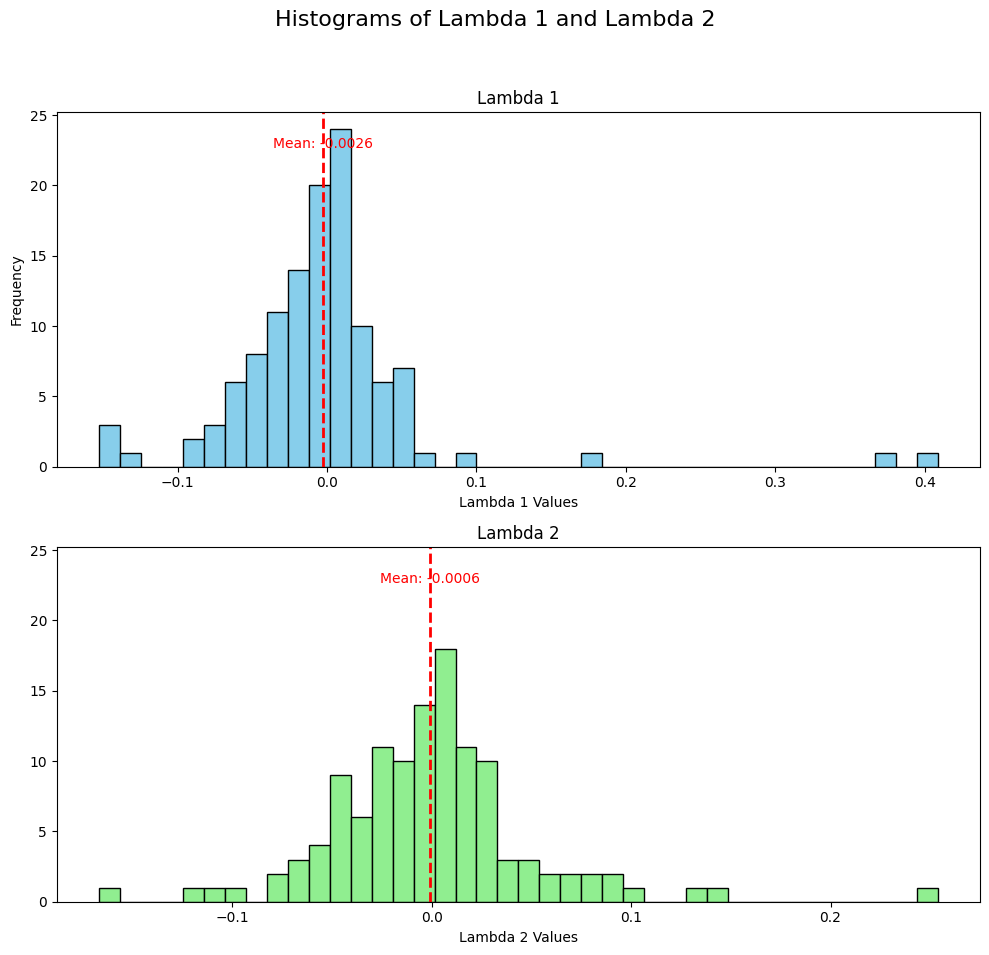

In [4]:
plot_gamma_histograms(gammas)

### <center>Obtain Final Gammas with T-Statistic and P-Test</center>

In [5]:
# Clean
gammas['Gamma 1'] = pd.to_numeric(gammas['Gamma 1'], errors='coerce')
gammas['Gamma 2'] = pd.to_numeric(gammas['Gamma 2'], errors='coerce')

# Calculate means
mean_gamma1 = gammas['Gamma 1'].mean()
mean_gamma2 = gammas['Gamma 2'].mean()

# Perform t-tests
t_test_gamma1 = stats.ttest_1samp(gammas['Gamma 1'], 0)
t_test_gamma2 = stats.ttest_1samp(gammas['Gamma 2'], 0)

summary_results_data = {
    "Parameter": ["Gamma 1", "Gamma 2"],
    "Mean": [mean_gamma1, mean_gamma2],
    "T-Statistic": [t_test_gamma1.statistic, t_test_gamma2.statistic],
    "P-Value": [t_test_gamma1.pvalue, t_test_gamma2.pvalue]
}

summary_results_df = pd.DataFrame(summary_results_data)

styled_df = summary_results_df.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('font-size', '12pt'), ('background-color', 'lightgrey'), ('color', 'black'), ('border-color', 'white')]
    }]
).set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border': '1px solid black'
}).applymap(
    lambda x: 'font-weight: bold' if isinstance(x, float) and x < 0.05 else '',
    subset=['P-Value']
).format({
    'Mean': "{:.6f}",
    'T-Statistic': "{:.4f}",
    'P-Value': "{:.4f}"
})

display(styled_df)

/var/folders/2_/86b4jc217ysdc4kf9wj_zbgh0000gn/T/ipykernel_3700/1779570993.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(


,Parameter,Mean,T-Statistic,P-Value
0,Gamma 1,-0.002601,-0.4179,0.6768
1,Gamma 2,-0.000644,-0.1366,0.8916


### <center>Gamma Values and Distribution Interpretation</center>

**Gamma 1 (Coefficient for Beta)**
- **Mean:** -0.002601
- **T-Statistic:** -0.4179
- **P-Value:** 0.6768

**Interpretation:**
Gamma 1's slightly negative mean and its distribution centered around zero indicate a negligible influence of market beta on excess returns. The insignificance, confirmed by a high P-value, suggests that the value is not statistically significantly different from zero. Hence, there is no consistent impact of market beta across the analyzed months.

**Gamma 2 (Coefficient of Upside Ratio Factor)**
- **Mean:** -0.000644
- **T-Statistic:** -0.1366
- **P-Value:** 0.8916

**Interpretation:**
Gamma 2 shows a slightly negative mean, suggesting a potential negligible impact of the investment strategy on excess returns. However, the effect is not statistically significant across the sample period, as indicated by the high P-value. The distribution supports this, with values clustering around zero, lacking consistent statistical backing.

### <center>Conclusion</center>
Both Gamma 1 and Gamma 2 distributions reflect considerable variability with most values clustering near zero, indicating no strong, consistent influence from either market beta or the investment strategy factor. While individual months might display significant relationships, these do not aggregate into a reliable pattern over the sample period, underscoring the complex dynamics at play in predicting excess returns through these variables.